In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from awesome.run.functions import *

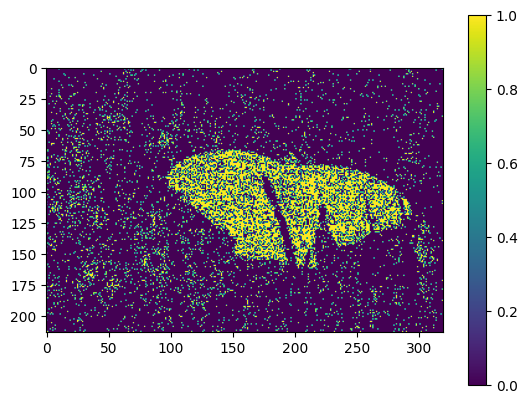

In [2]:
img_dir="butter2.jpg"
img_pil=Image.open(img_dir)
width, height = img_pil.size 
newsize = (int(width/2), int(height/2))
img_pil = img_pil.resize(newsize)

img= np.array(img_pil, dtype='float')/255.0
img = img[:,:,0:3] 
#img = np.pad(img, pad_width=((4,4),(4,4),(0,0)),constant_values=1.0)
nx,ny,nc = img.shape
img = img + 0.15*np.random.randn(nx,ny,nc)

likelihood = img[:,:,1] - 0.5*(img[:,:,0]+img[:,:,2])
likelihood = torch.from_numpy(likelihood<0.05).float()

im = Image.fromarray(255*(likelihood<0.5).numpy().astype('uint8'))
im.save("naive_mask.png")


def minmax(v: torch.Tensor,
           v_min: Optional[torch.Tensor] = None,
           v_max: Optional[torch.Tensor] = None,
           new_min: torch.Tensor = 0.,
           new_max: torch.Tensor = 1.,
           ) -> torch.Tensor:
    if v_min is None:
        v_min = torch.min(v)
    if v_max is None:
        v_max = torch.max(v)
    return (v - v_min)/(v_max - v_min)*(new_max - new_min) + new_min

img_norm = minmax(torch.from_numpy(img).float()).numpy()


plt.imshow(likelihood)
plt.colorbar()
plt.show()


In [3]:
PI  = torch.tensor(np.pi)
class myNet(nn.Module):
    def __init__(self,n_hidden):
        # call constructor from superclass
        super().__init__()
        
        
        # define network layers
        self.offset = torch.nn.Parameter(torch.zeros(1,2))
        #self.offset.requires_grad = True
        self.orientation = torch.nn.Parameter(-0.05*torch.ones(1))
        #self.orientation.requires_grad = True
        
        self.W0 = nn.Linear(3, n_hidden)
        self.W1 = nn.Linear(n_hidden, n_hidden)
        self.W2 = nn.Linear(n_hidden, 1)
        
        
    def forward(self, x,symmetry_prior):
        # define forward pass
        
        #x = self.orientation(x)
        x = x+self.offset
        r = torch.sqrt(torch.sum(x**2,dim=1, keepdim=True))
        x = x/(0.001+r)
        #x = x@torch.tensor([[torch.cos(self.orientation), torch.sin(self.orientation)],[-torch.sin(self.orientation), torch.cos(self.orientation)]], requires_grad=True)
        x = torch.cat(((x[:,0]*torch.cos(self.orientation) - x[:,1]*torch.sin(self.orientation))[:,None],(x[:,0]*torch.sin(self.orientation) + x[:,1]*torch.cos(self.orientation))[:,None]), dim=1)   
        if symmetry_prior:
            x = torch.cat((x[:,0][:,None],torch.abs(x[:,1])[:,None]), dim=1) 
        
        x = torch.cat((x,r), dim=1)
        x = F.relu(self.W0(x))
        x = F.relu(self.W1(x))
        x = self.W2(x) 
        return x

In [5]:

def extractInformationFromLikelihood(likelihood, mask):
    indices = torch.nonzero(mask)
    N_fore = indices.shape[0]
    print(N_fore)
    pixel_info = torch.zeros((N_fore,2)) # store x,y values of all pixels the user marked as foreground

    labels = torch.zeros(N_fore)
    pixel_info[:,0] = indices[:,0] / nx -0.5
    pixel_info[:,1] = indices[:,1] / ny -0.5
    labels = likelihood[mask]
    return pixel_info, labels

net = myNet(150)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)  

num_epochs = 10000
pix_back,labels_back = extractInformationFromLikelihood(likelihood,  likelihood<0.5)
pix_fore,labels_fore = extractInformationFromLikelihood(likelihood, likelihood>0.5)


number = 500
symmetry_prior = False
# Train the model
for epoch in range(num_epochs):
    perm = torch.randperm(pix_back.size(0))
    idx = perm[:number]
    random_pix_back = pix_back[idx,:]
    pix_back_labels = labels_back[idx]
    
    perm = torch.randperm(pix_fore.size(0))
    idx = perm[:number]
    random_pix_fore = pix_fore[idx,:]
    pix_fore_labels = labels_fore[idx]
    
    
    outputs_back = torch.sigmoid(net(random_pix_back,symmetry_prior)).squeeze()
    outputs_fore = torch.sigmoid(net(random_pix_fore,symmetry_prior)).squeeze()
    
    loss = 2*criterion(outputs_back, pix_back_labels) + 1*criterion(outputs_fore, pix_fore_labels)
    #if epoch >100:
    #    loss += 0.1*torch.sum(torch.sigmoid(net(-net.offset.data)))
    
    #print(torch.sigmoid(net(net.offset.data)))
    if epoch > 500:
        symmetry_prior=True
        
    # Backprpagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if (epoch+1) % 400 == 0:
        print ('Epoch [{}/{}],  Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))
        
        print(net.orientation.data)


57376
10784
Epoch [400/10000],  Loss: 0.4275
tensor([-0.0955], device='cuda:0')
Epoch [800/10000],  Loss: 0.4599
tensor([0.1815], device='cuda:0')
Epoch [1200/10000],  Loss: 0.4412
tensor([0.2440], device='cuda:0')
Epoch [1600/10000],  Loss: 0.4538
tensor([0.2431], device='cuda:0')
Epoch [2000/10000],  Loss: 0.4403
tensor([0.2464], device='cuda:0')
Epoch [2400/10000],  Loss: 0.4675
tensor([0.2469], device='cuda:0')
Epoch [2800/10000],  Loss: 0.4489
tensor([0.2506], device='cuda:0')
Epoch [3200/10000],  Loss: 0.4458
tensor([0.2451], device='cuda:0')
Epoch [3600/10000],  Loss: 0.4276
tensor([0.2436], device='cuda:0')
Epoch [4000/10000],  Loss: 0.4027
tensor([0.2437], device='cuda:0')
Epoch [4400/10000],  Loss: 0.4230
tensor([0.2463], device='cuda:0')
Epoch [4800/10000],  Loss: 0.4633
tensor([0.2523], device='cuda:0')
Epoch [5200/10000],  Loss: 0.4347
tensor([0.2420], device='cuda:0')
Epoch [5600/10000],  Loss: 0.4692
tensor([0.2492], device='cuda:0')
Epoch [6000/10000],  Loss: 0.3813
ten

myNet(
  (W0): Linear(in_features=3, out_features=150, bias=True)
  (W1): Linear(in_features=150, out_features=150, bias=True)
  (W2): Linear(in_features=150, out_features=1, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68160


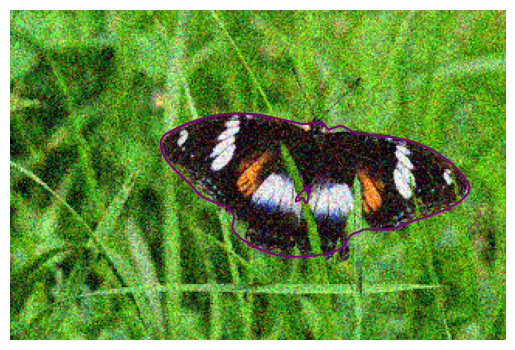

In [6]:
allPixels,temp = extractInformationFromLikelihood(likelihood,  likelihood>-0.5)

with torch.no_grad():
    pred_logits = net(allPixels,symmetry_prior).detach().reshape((nx,ny)) # torch tensor of size nx*ny
inferenceResult = pred_logits.detach().numpy()

im = Image.fromarray(255*(inferenceResult<0.5).astype('uint8'))
im.save("mask.png")

plt.imshow(img)
plt.contour(inferenceResult, levels=[0.0], colors='purple')
#plt.imshow(inferenceResult<0.5, cmap='binary', alpha=0.7)
plt.plot((-net.offset.data.detach().numpy()[0,1]+0.5)*ny, (-net.offset.data.detach().numpy()[0,0]+0.5)*nx,'x', color='purple')
#plt.colorbar()
plt.axis('off')
plt.savefig('mirror.png',bbox_inches='tight')
plt.show()

In [ ]:
plt.imshow(img)
plt.contour(likelihood, levels=[0.5], colors='purple')
#plt.imshow(inferenceResult<0.5, cmap='binary', alpha=0.7)
#plt.plot((-net.offset.data.detach().numpy()[0,1]+0.5)*ny, (-net.offset.data.detach().numpy()[0,0]+0.5)*nx,'x', color='purple')
#plt.colorbar()
plt.axis('off')
plt.savefig('mirror_naive.png',bbox_inches='tight')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


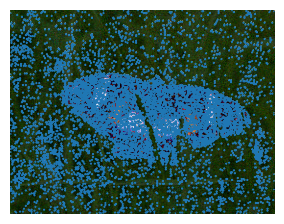

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


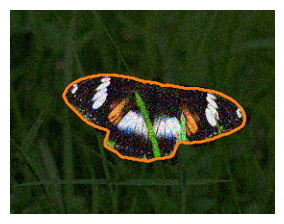

In [34]:
# Load mask
naive_mask = Image.open("naive_mask.png")
naive_mask = 1 - np.array(naive_mask, dtype='float')/255.0
projection_mask = Image.open("mask.png")
projection_mask = 1 - np.array(projection_mask, dtype='float')/255.0

from awesome.run.functions import *


mask_path = './original/mask.png'
orig_mask = load_mask_single_channel(mask_path) / 255

crop_y = slice(0, img.shape[0])
crop_x = slice(img.shape[1] // 6, img.shape[1])

constraint_name = "mirror"
image_name = "butterfly"
path = "./new/"
target_px = 1024
target_py = 768
actual_px = (crop_x.stop - crop_x.start)
actual_py = (crop_y.stop - crop_y.start)
# Recalculate crop start to get same aspect ratio as target_px and target_py
aspect = target_px / target_py
new_start = int(max(crop_x.start + ((actual_px - actual_py * aspect) / 2), 0))
crop_x = slice(int(new_start), int(actual_px * aspect + new_start))
actual_px = (crop_x.stop - crop_x.start)

naive = likelihood[crop_y, crop_x]
constraint = 1 - orig_mask[crop_y, crop_x]
pimg = img[crop_y, crop_x]
size = target_px / actual_px

def resize_img(path, target_px, target_py):
    img = Image.open(path)
    img = img.resize((target_px, target_py))
    img.save(path)

color = plt.get_cmap('tab10')(0)
save_path = path + f"{image_name}_{constraint_name}_naive.png"
plot_mask(pimg, naive, contour_linewidths=1, size=size, color=color, tight=True, save=True, override=True, path=save_path, auto_close=True, display=True)
resize_img(save_path, target_px, target_py)

color = plt.get_cmap('tab10')(1)
save_path = path + f"{image_name}_{constraint_name}.png"
plot_mask(pimg, constraint, size=size, color=color, tight=True, save=True, override=True, path=save_path, auto_close=True, display=True)
resize_img(save_path, target_px, target_py)

In [29]:
torch.tensor(pimg.shape) * size

tensor([ 816.8989, 1058.5168,   11.5056])

In [13]:
orig_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [20]:
from awesome.run.functions import *

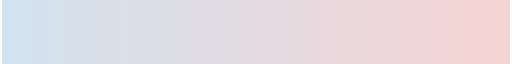

C:\Users\Schneider\AppData\Local\Temp\ipykernel_24420\3523525697.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_surf.show()


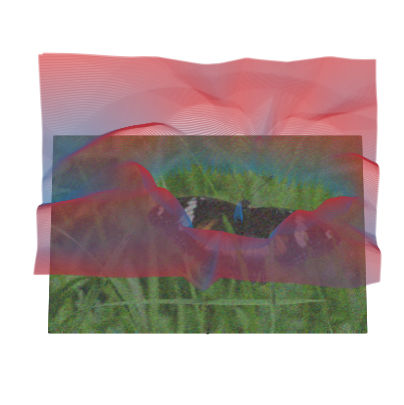

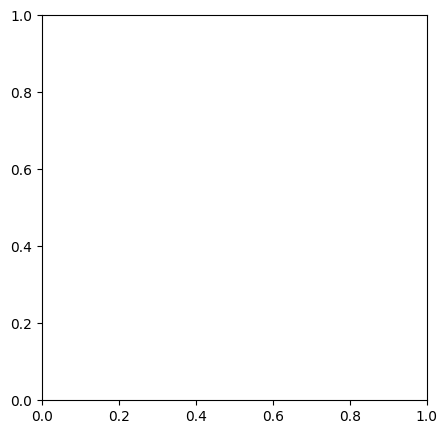

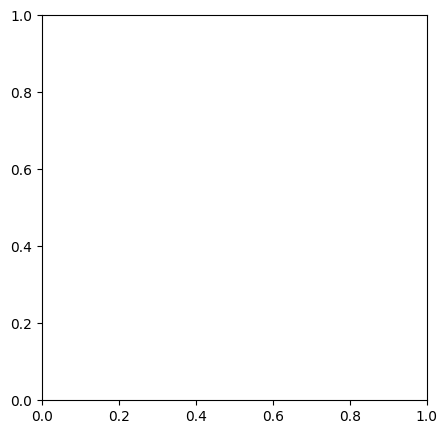

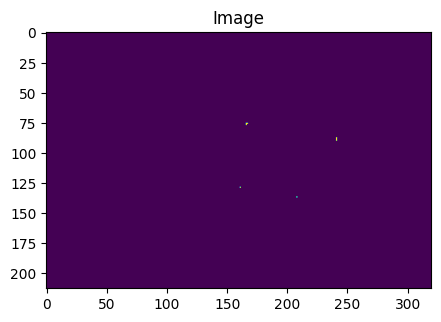

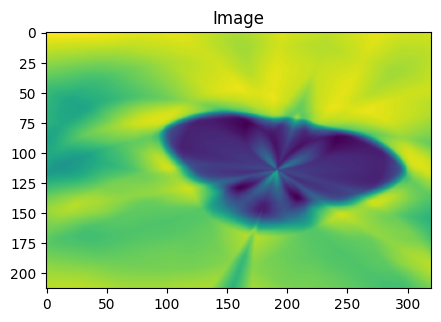

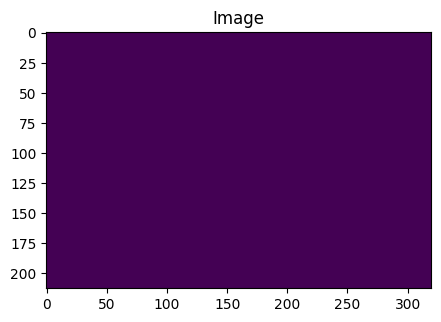

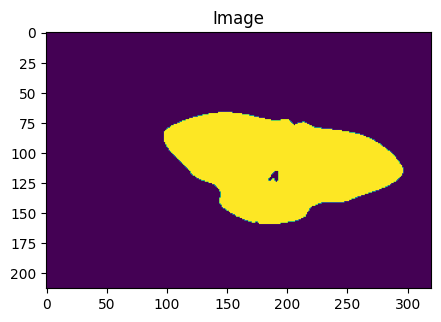

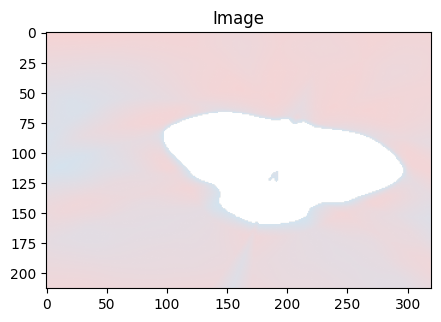

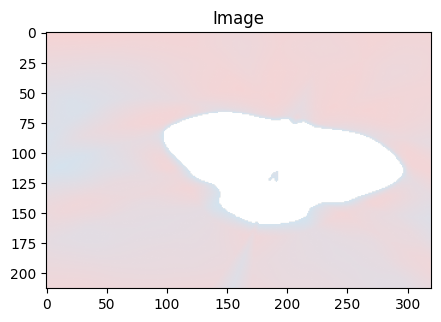

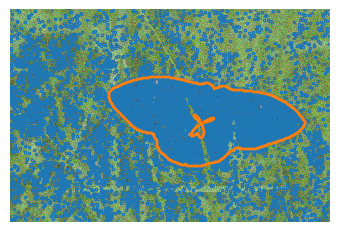

In [22]:
def image_subsample(img: torch.Tensor, factor: int = 6, mode: Literal["grid_sample", "slicing"] = "grid_sample"):
    if mode == "grid_sample":
        x = torch.arange(-1, 1, (2 * factor) / img.shape[-2])
        y = torch.arange(-1, 1, (2 * factor) / img.shape[-1])
        xx, yy = torch.meshgrid(x, y)
        flowgrid = torch.stack((yy, xx), dim=-1).float()[None,...]
        return F.grid_sample(img[None,...], flowgrid, align_corners=True)[0, ...]
    elif mode == "slicing":
        return img[..., ::factor, ::factor]
    else:
        raise ValueError("Invalid mode")

factor = 1

img_sub = image_subsample(torch.tensor(img_norm).permute(2,0,1).float(), factor)
res_hull_sub =  image_subsample(pred_logits.unsqueeze(0), factor)

mask_like_sub = image_subsample(likelihood.unsqueeze(0), factor) > 0.5
mask_pred_sub = res_hull_sub > 0.5

pred_log_inv = -1 * res_hull_sub
#pred_log_inv = torch.sigmoid(pred_log_inv)
#pred_log_inv -= 0.5
#pred_log_inv = torch.clip(pred_log_inv, -1e3, pred_log_inv.max())

fig_surf = plot_surface_logits(img_sub, pred_log_inv, 
    foreground_scribble_mask=torch.zeros(img_sub.shape[1:3]), 
    background_scribble_mask=torch.zeros(img_sub.shape[1:3]),
    image_subsampling=1,
    surface_log=False,
    surface_log_eps=1e-2,
    elevation=70,
    azimuth=-90,
    zoom=1.3,
    transparent=True,
    save=True, 
    path="./mirror_naive_and_cvx_surface", ext=["png"], override=True)

fig_surf.show()


In [9]:
torch.clip(pred_log_inv, 0, pred_log_inv.max()).min()

tensor(0.)

In [10]:
pred_log_inv.min()

tensor(-0.3977)

In [ ]:
plot_as_image(pred_log_inv, colorbar=True)

In [ ]:
fig = plot_mask_multi_channel(img_norm, np.stack([likelihood > 0.5, 1 - (inferenceResult > 0.5)], axis=2), size=3.2, tight=True, darkening_background=0.)
inpainted_img = torch.tensor(figure_to_numpy(fig, dpi=fig.dpi, transparent=False)[:, :, :3].astype(np.float32) / 255.0).permute(2,0,1).float()
inpainted_img_sub = image_subsample(inpainted_img, factor)

fig = plot_surface_logits(img_sub, res_hull_sub, 
    foreground_scribble_mask=torch.zeros(img_sub.shape[1:3]), 
    background_scribble_mask=torch.zeros(img_sub.shape[1:3]),
    image_subsampling=3,
    surface_log=True,
    surface_log_eps=1e-2,
    elevation=60,
    azimuth=-90,
    zoom=1.3,
    transparent=True,
    save=True, 
    path="./mirror_naive_and_cvx_surface_mask", ext=["png"], override=True)

In [ ]:
img_sub.dtype